In [8]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as plt_animation
import scipy as sp
import scienceplots
from scipy.integrate import odeint

In [9]:
#!pip install scienceplots
#En caso de no tener instalado el paquete scienceplots descomentar el codigo y ejecutar directamente en el notebook


In [10]:
class pendulum():
    def __init__(self, length, mass, theta_0, omega_0,t):
        self.L_num = length
        self.m_num = mass
        self.L = smp.symbols(f"L_{id(self)}")
        self.m = smp.symbols(f"m_{id(self)}")
        self.t = t
        self.theta = smp.Function(f'theta_{id(self)}')(self.t)
        self.omega = smp.Function(f'omega_{id(self)}')(self.t)
        self.x = 0
        self.y = 0
    def relative_position(self):
        # Nota: Esta es la posición con respecto la masa anterior, a la hora de expandirlo
        # se tiene que sumar la posición de las masas anteriores
        x = self.L*smp.sin(self.theta)
        y = -self.L*smp.cos(self.theta)
        return x,y

In [11]:
class N_pendulum_system():
    def __init__(self, g = 9.81):
        self.masses = [] # list of all the instances of class Pendulum
        self.g_num = g  # gravity
        self.g = smp.symbols(r"g")

    def add_mass(self, length, mass, theta_0, omega_0,t):
        self.masses.append(pendulum(length, mass, theta_0, omega_0,t))

    def lagrangian(self):
        kinetic = 0
        potential = 0
        position_x = 0
        position_y = 0
        for mass in self.masses:
            temp_x, temp_y = mass.relative_position()
            position_x += temp_x
            position_y += temp_y
            kinetic += smp.Rational(1,2)*mass.m*(smp.diff(position_x,mass.t)**2 + smp.diff(position_y,mass.t)**2)
            potential += position_y*mass.m*self.g
        kinetic = kinetic.simplify()
        potential = potential.simplify()
        return (kinetic - potential).simplify()

    def euler_lagrange(self):
        L = self.lagrangian()
        equations = []
        for mass in self.masses:
            # Derivada del Lagrangiano con respecto theta2 prima
            dLtheta_prim = smp.diff(L,smp.diff(mass.theta,mass.t)).simplify()
            # Derivada de la expresión anterior con respecto el tiempo
            ddLdttheta_prim = smp.diff(dLtheta_prim,mass.t).simplify()
            # Derivada del Lagrangiano con respecto theta1
            dLdtheta = smp.diff(L,mass.theta).simplify()
            equations.append((ddLdttheta_prim - dLdtheta).simplify())
        return equations

    def simulate(self,t_n,initial_conditions):
        equations = self.euler_lagrange()
        # Hay que establecer las segundas derivadas de los thetas en simbolos
        thetas_ddot = [smp.diff(mass.theta,mass.t,mass.t) for mass in self.masses]
        thetas_dot = [smp.diff(mass.theta,mass.t) for mass in self.masses]
        gen_sol = smp.solve(equations, thetas_ddot, rational = False)
        # Famous lambdify
        num_solutions = []
        for theta_ddot in thetas_ddot:
            num_solutions.append(
                smp.lambdify([self.masses[0].t] + [self.g] +
                             [mass.theta for mass in self.masses] +
                             [mass.L for mass in self.masses] +
                             [mass.m for mass in self.masses] +
                             [smp.diff(mass.theta,mass.t) for mass in self.masses],
                             gen_sol[theta_ddot], modules=["numpy"]))
        # Definir la funcion de derivada
        thetas_dot_num = [smp.lambdify([theta_dot], theta_dot) for theta_dot in thetas_dot]
        def derivative(S, t, g, *mass_params):
            # Split state vector into angles and angular velocities
            n = int(len(mass_params)/2)
            thetas = S[:n]
            omegas = S[n:]
            # Evaluate the accelerations
            theta_ddots = [
                f(
                    t, g, *thetas, *mass_params, *omegas
                )
                for f in num_solutions
            ]
            return [*omegas, *theta_ddots]
        # Have to extract the values from the object mass in every element of masses
        params = [mass.L_num for mass in self.masses] + [mass.m_num for mass in self.masses]
        result = odeint(
            derivative,
            y0=initial_conditions,
            t = t_n,
            args = (self.g_num, *params))
        return result

In [12]:
def get_position(thetas, masses):
    position_x = 0
    position_y = 0
    theta_sym = []
    L_sym = []
    L_num = []
    for mass in masses:
        theta_sym.append(mass.theta)
        L_sym.append(mass.L)
        L_num.append(mass.L_num)
        temp_x, temp_y = mass.relative_position()
        position_x += temp_x
        position_y += temp_y
        final_x = smp.lambdify(theta_sym+L_sym, position_x, modules=["numpy"])
        final_y = smp.lambdify(theta_sym+L_sym, position_y, modules=["numpy"])
        mass.x = final_x(*thetas[:len(theta_sym)],*L_num)
        mass.y = final_y(*thetas[:len(theta_sym)],*L_num)
    return [mass.x for mass in masses] + [mass.y for mass in masses]

In [13]:
# Create a system with three pendulums
n_pendulum = N_pendulum_system()
# Add pendulums to the system
t = smp.symbols(r"t")
n_pendulum.add_mass(2, 2, 5, 0,t)
n_pendulum.add_mass(1, 1, 5, 0,t)
#n_pendulum.add_mass(0.5, 1, 3, 0,t)
#n_pendulum.add_mass(1, 1, 5, 0,t)
# Time for simulation
t_n = np.linspace(0, 40, 1001)

# Initial conditions: [theta1, theta2, omega1, omega2, ...]
#initial_conditions = [5, 5, 3, 5, 0, 0, 0, 0]
initial_conditions = [5, 5, 0, 0]
# Simulate
solution = n_pendulum.simulate(t_n, initial_conditions)

# Extract the solution of the angles to calculate the positions in cartesian coordinates
thetas = solution.T[:int(len(solution.T)/2)]
positions = get_position(thetas, n_pendulum.masses)

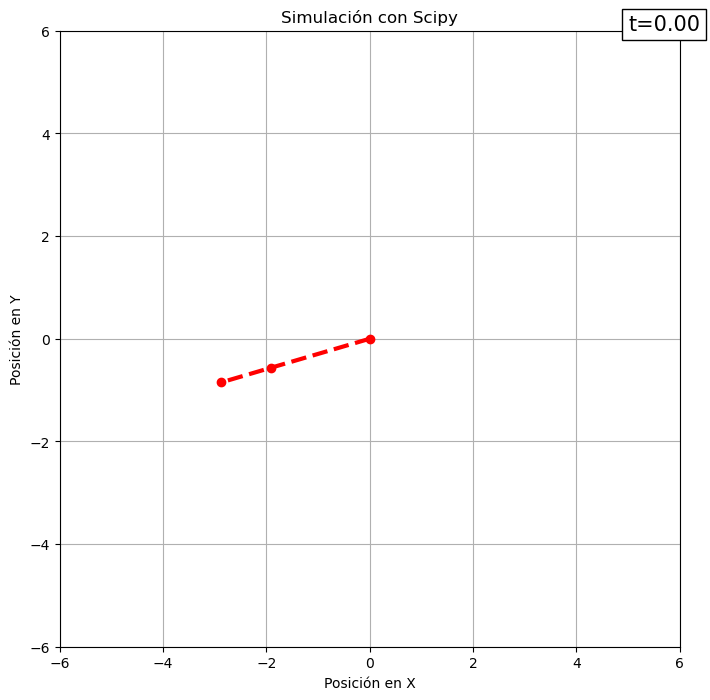

In [14]:
def animete(i):
    ln1.set_data([0]+[x[i] for x in x_positions], [0]+[y[i] for y in y_positions])
    time_text.set_text('t={:.2f}'.format(i/len(t_n[t_n<1])))

n = int(len(positions)/2)
x_positions = []
y_positions = []
for j in range(0, len(positions)):
    if n > j:
        x_positions.append([*positions[j]])
    else:
        y_positions.append([*positions[j]])

plt.style.use(["default"])
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_title('Simulación con Scipy')
ax.grid()
ln1, = plt.plot([],[], 'ro--', lw = 3)
time_text = ax.text(5,6,'',fontsize = 15 , bbox=dict(facecolor = 'white', edgecolor = "black"))
ax.set_xlabel("Posición en X")
ax.set_ylabel("Posición en Y")
ax.set_ylim(-6,6)
ax.set_xlim(-6,6)
ani = plt_animation.FuncAnimation(fig, animete, frames = 1000, interval = 50)
ani.save("test_4_pend.gif",writer= "pillow", fps =len(t_n[t_n<1]))